# Purpose:

2015-04-09 (Thursday)

Prepare data for figure generation.

# Implementation:

## Imports:

In [7]:
# imports
import sys
import os
import re

import datetime as dt

import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap

from shapely.geometry import Polygon, Point
from geopy.distance import distance
from geopy.point import Point as GpyPoint
import geopandas as gpd
import descartes as dct
from geopandas import GeoDataFrame
from descartes import PolygonPatch

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)

import seaborn as sns

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


# set figure characteristics

# size
sns.set_context("talk")

# style
sns.set_style("whitegrid")

## File paths:

In [9]:
# define paths to files
source_dir = '/home/gus/Dropbox/uganda_data/tsetse_database/districts'

all_xls_files_in_UGANDA_DATA = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/all_xls_files_in_UGANDA_DATA.txt"

traps_gps_geojson = "/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/traps/uganda_villages_gps_beadell.geojson"
village_gps_geojson = "/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/villages/uganda_villages_gps_beadell.geojson"

#Uganda map shapes
uganda_map = "/home/gus/OLD_DROPBOX/GIS/uganda/humanitarianresponse.info/uganda_district2010/Uganda_districts2010.geojson"


In [10]:
uganda_gdf = GeoDataFrame.from_file(uganda_map)

# Load Trap and Village geojsons

In [11]:
traps_gps = GeoDataFrame.from_file(traps_gps_geojson)
village_gps = GeoDataFrame.from_file(village_gps_geojson)

In [12]:
traps_gps.head()

,Latitude,Location,Longitude,geometry
0,2.382780,AP?,33.045000,POINT (33.045 2.38278)
1,1.975600,AP?,32.538600,POINT (32.5386 1.9756)
2,1.068104,BB,33.777342,POINT (33.777342 1.068104)
3,1.072800,BB,33.779530,POINT (33.77953 1.0728)
4,1.072500,BB,33.779380,POINT (33.77938 1.0725)


In [32]:
village_gps.query('Location == "MS"')

,Latitude,Location,Longitude,geometry
21,1.61945,MS,31.718617,POINT (31.71861666666667 1.61945)


## Collect the files and create master dataframe

In [13]:
workbooks = []

In [14]:
for name in os.listdir(source_dir):
#     print os.path.splitext(name)
    if os.path.splitext(name)[-1].startswith('.xls'):
        workbooks.append(name)

In [15]:
workbooks[:5]

['Wakiso.xlsx',
 'Masindi.xlsx',
 'Kamwenge.xlsx',
 'Busia_yoosook.xls',
 'Apac.xlsx']

In [16]:
colsite_sheets = []

In [17]:
def load_xl_sheets(xl_path,sheet_startswith="COLSITE",keep_default_na=True):
    dfs = {}

    xls = pd.ExcelFile(xl_path)
    
    for sheet in xls.sheet_names:
        if sheet.upper().startswith(sheet_startswith):
            dfs[sheet] = pd.read_excel(io=xl_path,
                                       sheetname=sheet,
                                       na_values=[],
                                       keep_default_na=keep_default_na
                                      )

    return dfs

In [18]:
for wkbk in workbooks:
    dfs = load_xl_sheets(os.path.join(source_dir, wkbk),keep_default_na=False)
    
    for name, df in dfs.items():
        dfs[name]['source_file'] = wkbk
        colsite_sheets.append(dfs[name])
        
    
    

In [19]:
def save_geojson(gdf,path):
    with open(path, 'w') as geo_out:
        geo_out.write(gdf.to_json())

In [20]:
def extent_from_gdfs(gdf1,gdf2,margin=0,):
    """
    Returns intersection of gdf1 with rectangle infered from data in gdf2.
    """
    # define the coordinates at the extent of our point data for our map
    margin_width = margin
    lon_range = [gdf2['Longitude'].min() - margin_width, gdf2['Longitude'].max() + margin_width]
    lat_range = [gdf2['Latitude'].min() - margin_width, gdf2['Latitude'].max() + margin_width]

    # create a rectangle from these coordinates
    spatial_extent = Polygon([(lon_range[0], lat_range[0]),
        (lon_range[0], lat_range[1]),
        (lon_range[1], lat_range[1]),
        (lon_range[1], lat_range[0])])

    # get the shapes with geopandas intersects, which pulls the full shape
    return gdf1[gdf1['geometry'].intersects(spatial_extent)]

In [21]:
def plot_points_on_base_geometries(points,
                                   base,
                                   auto_extent=True,
                                   title="",
                                   buf=None,
                                   points_by_col=None,
                                   base_by_column=None,
                                   base_legend=False
                                  ):
    
    assert isinstance(points, gpd.GeoDataFrame)
    assert isinstance(base, gpd.GeoDataFrame)
    assert isinstance(auto_extent,bool)
    assert isinstance(title, str)
    
    p = points.copy()
    
    if auto_extent:
        ext = extent_from_gdfs(base, points)
    else:
        ext = base
    
    if buf is not None:
        p.loc[:,'geometry'] = points.buffer(buf)


    if base_by_column is not None:
        ext.plot(column=base_by_column, legend=base_legend)
        
    else:
        ext.plot()
        
    p.plot()
    
    if points_by_col is not None:
        plot_labels(points,label_column=points_by_col)

    plt.title(title);

In [22]:
table = pd.concat(colsite_sheets)

In [24]:
test = ""

In [ ]:
test.find

In [23]:
table.head()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Wakiso.xlsx
1,AP?,Apac,,1.9756,32.5386,Uganda,Apac,,,,,,,,,Wakiso.xlsx
2,BB,Bulanga B,,1.068104,33.77734,Uganda,Budaka,20,,,,,,,,Wakiso.xlsx
3,BB20,Bulanga B Trap 20,,1.0728,33.77953,Uganda,Budaka,20,,,,,,,,Wakiso.xlsx
4,BB21,Bulanga B Trap 21,,1.0725,33.77938,Uganda,Budaka,21,,,,,,,,Wakiso.xlsx


In [35]:
name_MS_mask = table.name.apply(lambda name: name.upper().find('MAS') != -1)
name_OT_mask = table.name.apply(lambda name: name.upper().find('OTU') != -1)
name_NB_mask = table.name.apply(lambda name: name.upper().find('NAT') != -1)
name_KG_mask = table.name.apply(lambda name: name.upper().find('KG') != -1)

In [36]:
table[name_KG_mask]

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file


In [16]:
floatable = table.latitude.apply(lambda x: x is not '')

In [17]:
floatable_indexes = list(table[floatable].index)

In [18]:
table_latlon = table.ix[floatable_indexes]

In [19]:
table_latlon.latitude.apply(lambda x: x is '').unique()

array([False], dtype=object)

In [20]:
table_latlon.latitude.apply(type).unique()

array([<type 'float'>, <type 'unicode'>], dtype=object)

In [21]:
table_latlon.latitude.astype(np.float).apply(type).unique()

array([<type 'numpy.float64'>], dtype=object)

In [22]:
table_latlon.loc[:,'latitude'] = table_latlon.latitude.astype(np.float, copy=False)
table_latlon.loc[:,'longitude'] = table_latlon.longitude.astype(np.float, copy=False)

/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/core/indexing.py:486: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/core/indexing.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Pull out data for uganda and make the maps

In [23]:
letter_code = re.compile(u'^\D+', re.UNICODE)

def deduce_village(df):

    recode_func = lambda x: letter_code.findall(x)[0]

    village = df.id.apply(recode_func)
    df.loc[:,"village_code"] = village

In [24]:
# pdb

In [25]:
table_latlon.tail()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kabarole.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kumi.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Arua.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Budaka.xlsx
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Busia.xlsx


In [26]:
table_latlon = table_latlon.drop_duplicates()
deduce_village(table_latlon)

In [27]:
table_latlon.tail()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file,village_code
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kabarole.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Kumi.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Arua.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Budaka.xlsx,UGT
282,UGT,Ochuloi,,1.846,33.1509,Uganda,Dokolo/Kaberamaido,53,,,,,,,,Busia.xlsx,UGT


In [28]:
uganda_with_dups = table_latlon.query('country == "Uganda"')

In [29]:
uganda_with_dups.head()

,id,name,gaz_id,latitude,longitude,country,district,province,category,submitter,submission_date,curator,curation_date,public_notes,internal_notes,source_file,village_code
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Wakiso.xlsx,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Masindi.xlsx,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Kamwenge.xlsx,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Busia_yoosook.xls,AP?
0,AP?,Apala,,2.38278,33.045,Uganda,Lira,,,,,,,,,Apac.xlsx,AP?


In [30]:
uganda = uganda_with_dups[["id", "name", "gaz_id", "latitude", "longitude", "country", "district", "village_code"]]
uganda = uganda.drop_duplicates()
print len(uganda), len(uganda_with_dups)
uganda.head()

265 7420


,id,name,gaz_id,latitude,longitude,country,district,village_code
0,AP?,Apala,,2.382780,33.045000,Uganda,Lira,AP?
1,AP?,Apac,,1.975600,32.538600,Uganda,Apac,AP?
2,BB,Bulanga B,,1.068104,33.777342,Uganda,Budaka,BB
3,BB20,Bulanga B Trap 20,,1.072800,33.779530,Uganda,Budaka,BB
4,BB21,Bulanga B Trap 21,,1.072500,33.779380,Uganda,Budaka,BB


# Collect all trap GPS, save it

In [31]:
def lat_lon_to_geometry(df,lat='Latitude',lon='Longitude'):
    df["geometry"] = map(Point, df[lon], df[lat])

In [32]:
traps_gps = pd.DataFrame()
villages_gps = pd.DataFrame()

In [33]:
uganda['latitude'].apply(type).head()

0    <type 'numpy.float64'>
1    <type 'numpy.float64'>
2    <type 'numpy.float64'>
3    <type 'numpy.float64'>
4    <type 'numpy.float64'>
Name: latitude, dtype: object

In [34]:
traps_gps['Location'] = uganda['village_code']
traps_gps['Latitude'] = uganda['latitude']
traps_gps['Longitude'] = uganda['longitude']

lat_lon_to_geometry(traps_gps,lat='Latitude',lon='Longitude')
traps_gps = GeoDataFrame(traps_gps, geometry='geometry')

# traps_gps['Latitude'].apply(type).head()

In [35]:
print len(traps_gps)
print len(traps_gps.drop_duplicates())

265
265


In [36]:
# save geojson
# save_geojson(traps_gps,traps_gps_geojson)

In [37]:
print traps_gps_geojson

/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/traps/uganda_villages_gps_beadell.geojson


# Generate Village GPS and save it

In [38]:
village_gps = pd.pivot_table(traps_gps,index=['Location'],
                      values=['Longitude','Latitude'],
                      fill_value=0,
                      aggfunc=[np.median])
# print village_gps.head()
village_gps = village_gps['median']
village_gps = village_gps.reset_index()
# village_gps.head()

lat_lon_to_geometry(village_gps)
village_gps = GeoDataFrame(village_gps, geometry='geometry')
village_gps.head()

,Location,Latitude,Longitude,geometry
0,AP?,2.179190,32.791800,POINT (32.7918 2.17919)
1,BB,1.068104,33.778490,POINT (33.77849 1.068104)
2,BD,0.260897,33.929442,POINT (33.92944166666666 0.2608966666666667)
3,BG,1.619185,33.289898,POINT (33.28989846153846 1.619185)
4,BK,1.011333,33.861239,POINT (33.86123916666666 1.011333333333333)


In [39]:
# # save geojson
# save_geojson(village_gps,village_gps_geojson)
print village_gps_geojson

/home/gus/Dropbox/uganda_data/data_repos/field_data/locations/gps/villages/uganda_villages_gps_beadell.geojson


In [40]:
# add geopy.Point column for distance calcs

get_geopy_point = lambda row: GpyPoint(latitude=row.Latitude, longitude=row.Longitude)

village_gps['geopy_point'] = village_gps.apply(get_geopy_point,axis=1)
village_gps.head()

,Location,Latitude,Longitude,geometry,geopy_point
0,AP?,2.179190,32.791800,POINT (32.7918 2.17919),"2° 10′ 45.084″ N, 32° 47′ 30.48″ E"
1,BB,1.068104,33.778490,POINT (33.77849 1.068104),"1° 4′ 5.1744″ N, 33° 46′ 42.564″ E"
2,BD,0.260897,33.929442,POINT (33.92944166666666 0.2608966666666667),"0° 15′ 39.228″ N, 33° 55′ 45.99″ E"
3,BG,1.619185,33.289898,POINT (33.28989846153846 1.619185),"1° 37′ 9.066″ N, 33° 17′ 23.6345″ E"
4,BK,1.011333,33.861239,POINT (33.86123916666666 1.011333333333333),"1° 0′ 40.8″ N, 33° 51′ 40.461″ E"


In [41]:
traps_gps['geopy_point'] = traps_gps.apply(get_geopy_point,axis=1)
traps_gps.head()

,Location,Latitude,Longitude,geometry,geopy_point
0,AP?,2.382780,33.045000,POINT (33.045 2.38278),"2° 22′ 58.008″ N, 33° 2′ 42″ E"
1,AP?,1.975600,32.538600,POINT (32.5386 1.9756),"1° 58′ 32.16″ N, 32° 32′ 18.96″ E"
2,BB,1.068104,33.777342,POINT (33.777342 1.068104),"1° 4′ 5.1744″ N, 33° 46′ 38.4312″ E"
3,BB,1.072800,33.779530,POINT (33.77953 1.0728),"1° 4′ 22.08″ N, 33° 46′ 46.308″ E"
4,BB,1.072500,33.779380,POINT (33.77938 1.0725),"1° 4′ 21″ N, 33° 46′ 45.768″ E"


In [42]:
len(village_gps)

36

# Pull out all sheets that start with "Tryp"

In [43]:
# get the list of excel files
paths = []

with open(all_xls_files_in_UGANDA_DATA,'rU') as all_xls:
    for line in all_xls:
        paths.append(line.rstrip('\n'))

In [44]:
# pdb

In [45]:
tryp_sheets = []
for wkbk in paths:
    dfs = load_xl_sheets(wkbk, sheet_startswith="TRYPAN")
    
    for name, df in dfs.items():
        dfs[name]['source_file'] = wkbk
        tryp_sheets.append(dfs[name])

df_tryps = pd.concat(tryp_sheets)

In [46]:
df_tryps.head()

,ITS1_assay,NRP_assay,SRA_Gibson,SRA_Radwanska,T. brucei,T. brucei COI sequence,T. brucei COI_Seq,Unnamed: 7,banked_sample_ID_fly,banked_sample_ID_trypanosome,banked_sample_id,banked_sample_id_trypanosome,curation_date,curator,internal_notes,public_notes,source_file,status,submission_date,submitter,trypanosome presence


In [47]:
len(tryp_sheets)

48

##  Load data from the prevalence paper from Chaz

In [48]:
wolbachia_data_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/prevalence_paper_files/2015-03-25_chaz_data/wolbachia_data.xlsx"

wolbachia_data_orig = pd.read_excel(io=wolbachia_data_path,
                                       sheetname=0,
                                       na_values=[],
                                       keep_default_na=False
                                      )
wolbachia_data_orig.head()

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
0,AP113,AP,,R,,Y,,,,N
1,AP114,AP,,R,,Y,,,,N
2,AP115,AP,,R,,Y,,,,N
3,AP116,AP,,R,,Y,,,,N
4,AP117,AP,,R,,Y,,,,N


In [49]:
wgro_sghv_ttub_infection_path = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/prevalence_paper_files/2015-03-25_chaz_data/wgro_sghv_ttub_infection.tsv"

wgro_sghv_ttub_infection = pd.read_csv(filepath_or_buffer=wgro_sghv_ttub_infection_path, sep='\t', na_filter=False)
wgro_sghv_ttub_infection.head()

,﻿ID,mtDNA,msat,GeoGen,Pop,Sex,Wgro,SGHV,Ttub
0,BK09001,N,N,NE,BK,F,1,0,0
1,BK09003,N,N,NE,BK,F,0,0,0
2,BK09006,N,N,NE,BK,M,1,0,0
3,BK09007,N,N,NE,BK,M,1,0,0
4,BK09009,N,N,NE,BK,M,1,0,0


In [50]:
wgro_sghv_ttub_infection.Pop.unique()

array(['BK', 'BN', 'PT', 'OS', 'DK', 'AR', 'MY', 'KL', 'NA', 'BU', 'BV',
       'JN', 'SS', 'MS', 'KR', 'KF', 'KB', 'KK'], dtype=object)

### Positives listed as from 'NA' population in `wgro_sghv_ttub_infection.tsv`

In [51]:
wgro_sghv_ttub_infection.query("Pop == 'NA'")

,﻿ID,mtDNA,msat,GeoGen,Pop,Sex,Wgro,SGHV,Ttub
206,KT08_01,S,S,SC,NA,F,0,0,0
207,KT08_02,S,S,SC,NA,F,0,0,0
208,KT08_03,S,S,SC,NA,na,0,0,0
209,NA08_01,S,S,SC,NA,M,1,0,0
210,NA08_02,S,S,SC,NA,M,0,0,0
211,NA08_03,S,S,SC,NA,F,0,0,0
212,NA08_04,S,S,SC,NA,F,0,0,0
213,NA08_05,S,S,SC,NA,F,0,0,0
214,NA08_06,S,S,SC,NA,F,0,0,0
215,NA08_07,S,S,SC,NA,M,0,1,1


In [52]:
wolbachia_data_orig.query("Population == 'NA'")

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
709,KT08_01,NA,F,W,2009,N,Y,N,N,S
710,KT08_02,NA,F,W,2009,N,N,N,N,S
711,KT08_03,NA,,W,2009,N,N,N,N,S
712,NA08_01,NA,M,W,2008,Y,N,,,S
713,NA08_02,NA,M,W,2008,N,N,N,N,S
714,NA08_03,NA,F,W,2008,N,N,N,N,S
715,NA08_04,NA,F,W,2008,N,Y,N,N,S
716,NA08_05,NA,F,W,2008,N,N,N,N,S
717,NA08_06,NA,F,W,2008,N,N,N,N,S
718,NA08_07,NA,M,W,2008,N,N,Y,Y,S


In [53]:
uganda.query("district == 'Wakiso'")

,id,name,gaz_id,latitude,longitude,country,district,village_code
127,KT,Kitubulu Village,,0.08208,32.48505,Uganda,Wakiso,KT
229,NA,Nkumba,,0.05859,32.53198,Uganda,Wakiso,NA


# Reload files but use 'SAMPLE' not 'COLSITE' as the sheet

In [54]:
# pdb

In [55]:
samples = []
for wkbk in paths:
    if "uganda_data" in wkbk:
        try:
            dfs = load_xl_sheets(wkbk, sheet_startswith="SAMPLE", keep_default_na=False)

            for name, df in dfs.items():
#                 dfs[name]['source_file'] = wkbk
                samples.append(dfs[name])
        except IndexError as exc:
            if "list index out of range" in exc.message:
                pass

df_samples = pd.concat(samples)

In [56]:
df_samples = df_samples.drop_duplicates()

In [57]:
mask2008 = df_samples.collection_id.apply(lambda x: x.endswith('2008'))
mask2009 = df_samples.collection_id.apply(lambda x: x.endswith('2009'))

In [58]:
df_samples[mask2009].query("population == 'OT'")

,aliguot_n,aliquot_n,banked_sample_id,collection_date,collection_id,collection_id.1,curation_date,curator,food_state,id,internal_notes,internal_notes.1,life_stage,population,public_notes,sex,size,species_id,species_id.1,species_identification,species_identification_method_id,specimen_id,stoage,storage,submission_date,submitter,tissue,tube_num
0,NaN,,OT09001,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
1,NaN,,OT09002,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
2,NaN,,OT09003,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
3,NaN,,OT09004,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
4,NaN,,OT09005,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
5,NaN,,OT09006,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
6,NaN,,OT09007,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,F,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
7,NaN,,OT09008,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
8,NaN,,OT09009,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,F,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
9,NaN,,OT09010,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,F,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,


In [59]:
def plot_labels(gdf,label_column,offx=0.006,offy=0.004):
    
    pltme = lambda row: plt.text(x=row.Longitude+offx,
                                 y=row.Latitude+offy,
                                 s=row[label_column])
    
    gdf.apply(pltme,axis=1)
    
    

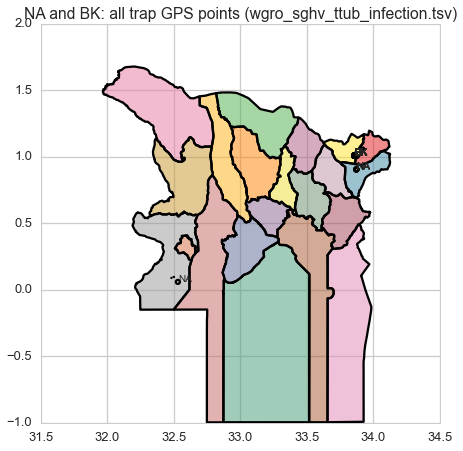

In [60]:
na = traps_gps.query("Location == 'NA'")
bk = traps_gps.query("Location == 'BK'")

na_bk = na.append(bk)

ext = extent_from_gdfs(uganda_gdf, na_bk)


na_bk.geometry = na_bk.buffer(0.015)


ext.plot(column='DNAME_2010') #, legend=True)
na_bk.plot()

plot_labels(na_bk,label_column='Location')

d = distance(na.geopy_point.iloc[0], bk.geopy_point.iloc[0]).kilometers
plt.title("NA and BK: all trap GPS points (wgro_sghv_ttub_infection.tsv)");



In [61]:
wolbachia_data_orig.query("Population == 'NA'")

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
709,KT08_01,NA,F,W,2009,N,Y,N,N,S
710,KT08_02,NA,F,W,2009,N,N,N,N,S
711,KT08_03,NA,,W,2009,N,N,N,N,S
712,NA08_01,NA,M,W,2008,Y,N,,,S
713,NA08_02,NA,M,W,2008,N,N,N,N,S
714,NA08_03,NA,F,W,2008,N,N,N,N,S
715,NA08_04,NA,F,W,2008,N,Y,N,N,S
716,NA08_05,NA,F,W,2008,N,N,N,N,S
717,NA08_06,NA,F,W,2008,N,N,N,N,S
718,NA08_07,NA,M,W,2008,N,N,Y,Y,S


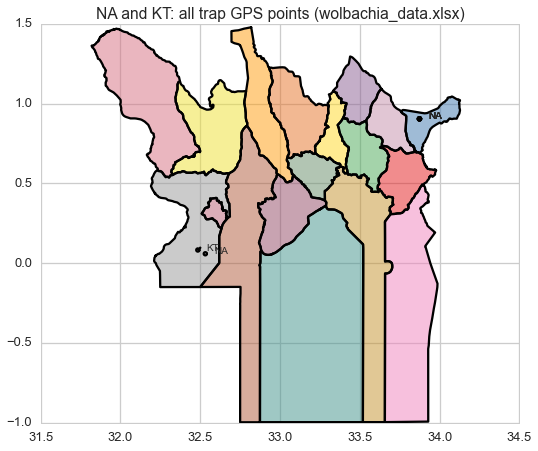

In [62]:
na = traps_gps.query("Location == 'NA'")
kt = traps_gps.query("Location == 'KT'")

na_kt = na.append(kt)

ext = extent_from_gdfs(uganda_gdf, na_kt)


na_kt.geometry = na_kt.buffer(0.01)


ext.plot(column='DNAME_2010', legend=False)
na_kt.plot()

plot_labels(na_kt,
            label_column='Location',
            offx=0.06,
            offy=0
           )

plt.title("NA and KT: all trap GPS points (wolbachia_data.xlsx)");

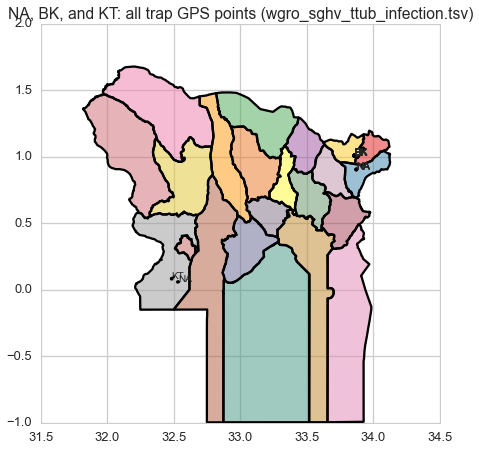

In [63]:
na = traps_gps.query("Location == 'NA'")
bk = traps_gps.query("Location == 'BK'")
kt = traps_gps.query("Location == 'KT'")

m1 = pd.merge(na,kt,how='outer')
na_bk_kt = pd.merge(m1,bk,how='outer')

ext = extent_from_gdfs(uganda_gdf, na_bk_kt)


na_bk_kt.geometry = na_bk_kt.buffer(0.005)


ext.plot(column='DNAME_2010') #, legend=True)
na_bk_kt.plot()

plot_labels(na_bk_kt,label_column='Location')

plt.title("NA, BK, and KT: all trap GPS points (wgro_sghv_ttub_infection.tsv)");

# Test data for things that "should" not happen in a "perfect" world

### ID-prefix codes should not be used in multiple districts

__Results:__

- AP:
    - Apac - 1
    - Lira - 1
- DK:
    - Dokolo - 1
    - Lira - 9
- NA:
    - Butaleja - 5
    - Wakiso - 1 
- UGT:
    - Dokolo - ?
    - Kaberamaido - ?

In [64]:
pd.set_option('display.max_rows', 1000)

In [66]:
uganda.pivot_table(index=['village_code','district'],
                   values=['id'],
                   aggfunc=[len]
                   )
           

len
                                 id
village_code district              
AP?          Apac                 1
             Lira                 1
BB           Budaka              11
BD           Busia                4
BG           Soroti              14
BK           Pallisa             18
BN           Butaleja            16
BU           Busia                7
BV           Mukono               7
DK           Dokolo               1
             Lira                 9
JN           Nakasongola         10
KA           Pallisa              9
KB           Kibaale              1
KK           Kabarole             1
KL           Mukono               1
KP           Budaka              11
KT           Wakiso               1
KW           Budaka              10
KY           Soroti               9
MF           Masindi             10
MK           Kumi                17
MP           Kamwenge             1
MS           Masindi             13
MY           Moyo                32
NA           Butaleja             5
             Wakiso               1
NB           Namutumba            1
OG                                1
OK           Busia               11
OM           Arua                 1
OS           Soroti               1
OT           Kaberamaido          1
OYa          Oyam                 6
PD                                1
SI           Busia                4
SR           Soroti               3
TR           Abwanget             1
UGT          Dokolo/Kaberamaido  13

### ID-prefix codes should not have multiple MEANINGFULLY DIFFERENT names

__Results:__

- BK:
    - Nabiswa
    - Kadama
- MY:
    - Kendi Village
    - Moyo
- NA:
    - Namadumu
    - Nkumba
- UGT:
        +--------------+---+
        | Aceniworo    | 1 |
        | Arachi Iguli | 1 |
        | Atama        | 3 |
        | Gorogoro     | 2 |
        | Ochuloi      | 1 |
        | Otolimoleo   | 3 |
        | Oyama        | 2 |
        +--------------+---+

In [67]:
uganda.pivot_table(index=['village_code','name'],
                   values=['id'],
                   aggfunc=[len]
                   )

len
                                                 id
village_code name                                  
AP?          Apac                                 1
             Apala                                1
BB           Bulanga B                            1
             Bulanga B Trap 20                    1
             Bulanga B Trap 21                    1
             Bulanga B Trap 22                    1
             Bulanga B Trap 23                    1
             Bulanga B Trap 24                    1
             Bulanga B Trap 25                    1
             Bulanga B Trap 26                    1
             Bulanga B Trap 27                    1
             Bulanga B Trap 28                    1
             Bulanga B Trap 29                    1
BD           Budonga                              1
             Budonga Trap 14                      1
             Budonga Trap 15                      1
             Budonga Trap 16                      1
BG           Bugondo                              1
             Bugondo Trap 1                       1
             Bugondo Trap 10                      1
             Bugondo Trap 11                      1
             Bugondo Trap 12                      1
             Bugondo Trap 13                      1
             Bugondo Trap 2                       1
             Bugondo Trap 3                       1
             Bugondo Trap 4                       1
             Bugondo Trap 5                       1
             Bugondo Trap 6                       1
             Bugondo Trap 7                       1
             Bugondo Trap 8                       1
             Bugondo Trap 9                       1
BK           Kadama                               1
             Kadama Trap 1                        1
             Kadama Trap 2                        1
             Kadama Trap 3                        1
             Kadama Trap 4                        1
             Kadama Trap 5                        1
             Kadama Trap 8                        1
             Nabiswa                              2
             Nabiswa Trap 1                       1
             Nabiswa Trap 2                       1
             Nabiswa Trap 3                       1
             Nabiswa Trap 4                       1
             Nabiswa Trap 6                       1
             Nabiswa Trap 7                       1
             Nabiswa Trap 8                       1
             Nabiswa location 1                   1
             Nabiswa location 2                   1
BN           Bunghazi                             1
             Bunghazi Trap 1                      1
             Bunghazi Trap 10                     1
             Bunghazi Trap 11                     1
             Bunghazi Trap 12                     1
             Bunghazi Trap 13                     1
             Bunghazi Trap 14                     1
             Bunghazi Trap 15                     1
             Bunghazi Trap 2                      1
             Bunghazi Trap 3                      1
             Bunghazi Trap 4                      1
             Bunghazi Trap 5                      1
             Bunghazi Trap 6                      1
             Bunghazi Trap 7                      1
             Bunghazi Trap 8                      1
             Bunghazi Trap 9                      1
BU           Busime                               1
             Busime Trap 10                       1
             Busime Trap 11                       1
             Busime Trap 12                       1
             Busime Trap 13                       1
             Busime Trap 8                        1
             Busime Trap 9                        1
BV           Buvuma Island                        1
             Buvuma Island Trap 1                 1
             Buvuma Island Trap 11                1
             Buvuma Island Trap 12          

In [68]:
df_samples.population.unique()

array([u'Omugo', u'BU', u'OK', u'SI', u'BD', u'BN', '', u'UGT', u'KK',
       u'OT', u'DK', u'SS', u'KS', u'MA', u'ND', u'KB', u'MK', u'Ogur',
       u'Apala', u'Pader', u'MS', u'MF', u'Moyo', u'BV', u'KL', u'JN',
       u'OY', u'KA', u'BK', u'KY', u'SR', u'BG', u'OS', u'KU', u'NA'], dtype=object)

### In `wolbachia_data.xls [Data_orig]` "populations" should only contain flies from "near-by" traps

In [69]:
wolbachia_data_orig.head()

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
0,AP113,AP,,R,,Y,,,,N
1,AP114,AP,,R,,Y,,,,N
2,AP115,AP,,R,,Y,,,,N
3,AP116,AP,,R,,Y,,,,N
4,AP117,AP,,R,,Y,,,,N


In [70]:
wolbachia_data_orig.pivot_table(
    index=['Population','ID'],
    values=['Date'],
    aggfunc=[len],
    margins=1
)

len
                     Date
Population ID            
AP         AP11         1
           AP113        1
           AP114        1
           AP115        1
           AP116        1
           AP117        1
           AP118        1
           AP119        1
           AP12         1
           AP120        1
           AP121        1
           AP122        1
           AP123        1
           AP124        1
           AP125        1
           AP129        1
           AP13         1
           AP130        1
           AP131        1
           AP132        1
           AP133        1
           AP134        1
           AP135        1
           AP136        1
           AP138        1
           AP139        1
           AP14         1
           AP140        1
           AP141        1
           AP143        1
           AP15         1
           AP18         1
           AP19         1
           AP2          1
           AP20         1
           AP21         1
           AP8          1
AR         Om29         1
           Om33         1
           Om36         1
           Om37         1
           Om38         1
           Om50         1
           Om51         1
           Om52         1
           Om53         1
           Om54         1
BK         BK09001      1
           BK09003      1
           BK09006      1
           BK09007      1
           BK09009      1
           BK09011      1
           BK09012      1
           BK09014      1
           BK09015      1
           BK09017      1
           BK09019      1
           BK09020      1
           BK09021      1
           BK09022      1
           BK09023      1
           BK09024      1
           BK09025      1
           BK09026      1
           BK09027      1
           BK09028      1
           BK09029      1
           BK09030      1
           BK09031      1
           BK09032      1
           BK09033      1
           BK09036      1
           BK09037      1
           BK09038      1
           BK09039      1
           Budaka1      1
           Budaka10     1
           Budaka11     1
           Budaka12     1
           Budaka13     1
           Budaka14     1
           Budaka15     1
           Budaka16     1
           Budaka17     1
           Budaka18     1
           Budaka19     1
           Budaka2      1
           Budaka24     1
           Budaka25     1
           Budaka26     1
           Budaka27     1
           Budaka3      1
           Budaka31     1
           Budaka39     1
           Budaka4      1
           Budaka40     1
           Budaka41     1
           Budaka45     1
           Budaka48     1
           Budaka49     1
           Budaka5      1
           Budaka50     1
           Budaka54     1
           Budaka55     1
           Budaka57     1
           Budaka58     1
           Budaka59     1
           Budaka6      1
           Budaka60     1
           Budaka62     1
           Budaka63     1
           Budaka7      1
           Budaka70     1
           Budaka8      1
           Budaka9      1
BN         BN09e0038    1
           BN09e0258    1
           BN09e0259    1
           BN09e0275    1
           BN09e0380    1
           BN09e0384    1
           BN09e0391    1
           BN09e0401    1
           BN09e0419    1
           BN09e0432    1
           BN09e0437    1
           BN09e0442    1
           BN09e0448    1
           BN09e0451    1
           BN09e0505    1
           BN1          1
           BN10_1       1
           BN10_3       1
           BN10_4       1
           BN10_5       1
           BN10_6       1
           BN11_1       1
           BN11_2       1
           BN1_1        1
           BN1_3        1
           BN2_1        1
           BN2_15       1
           BN2_2        1
           BN2_3        1
           BN3_1        1
           BN3_10       1
           BN3_11       1
           BN3_12       1
           BN3_2        1
           BN3_26       1
           BN3_27 

In [71]:
wolbachia_data_orig.query("Population == 'NA'")

,ID,Population,Sex,DNAsource,Date,Wgro,Wwsp,SGHV,Ttub,NorS
709,KT08_01,NA,F,W,2009,N,Y,N,N,S
710,KT08_02,NA,F,W,2009,N,N,N,N,S
711,KT08_03,NA,,W,2009,N,N,N,N,S
712,NA08_01,NA,M,W,2008,Y,N,,,S
713,NA08_02,NA,M,W,2008,N,N,N,N,S
714,NA08_03,NA,F,W,2008,N,N,N,N,S
715,NA08_04,NA,F,W,2008,N,Y,N,N,S
716,NA08_05,NA,F,W,2008,N,N,N,N,S
717,NA08_06,NA,F,W,2008,N,N,N,N,S
718,NA08_07,NA,M,W,2008,N,N,Y,Y,S


In [72]:
# NA prevalence in wolbachia_data_orig
NA_wol = wolbachia_data_orig.query("Population == 'NA'")

NA_wol_len = len(NA_wol)
NA_wol_positive = len(NA_wol.query('Ttub == "Y"'))

(float(NA_wol_positive)/NA_wol_len) * 100

20.0

In [73]:
df_samples.head()

,aliguot_n,aliquot_n,banked_sample_id,collection_date,collection_id,collection_id.1,curation_date,curator,food_state,id,internal_notes,internal_notes.1,life_stage,population,public_notes,sex,size,species_id,species_id.1,species_identification,species_identification_method_id,specimen_id,stoage,storage,submission_date,submitter,tissue,tube_num
0,NaN,NaN,Omugo1.1,1/x/08,Omugo01-2008,NaN,,,,,,NaN,,Omugo,storage N/A,F,1,G. fuscipes,NaN,NaN,,NaN,NaN,NaN,2010-06-10 00:00:00,J Beadell;B Symula;U Alam,NaN,1
1,NaN,NaN,Omugo1.2,1/x/08,Omugo01-2008,NaN,,,,,,NaN,,Omugo,storage N/A,M,1,G. fuscipes,NaN,NaN,,NaN,NaN,NaN,2010-06-10 00:00:00,J Beadell;B Symula;U Alam,NaN,2
2,NaN,NaN,Omugo1.3,1/x/08,Omugo01-2008,NaN,,,,,,NaN,,Omugo,storage N/A,M,1,G. fuscipes,NaN,NaN,,NaN,NaN,NaN,2010-06-10 00:00:00,J Beadell;B Symula;U Alam,NaN,3
3,NaN,NaN,Omugo1.4,1/x/08,Omugo01-2008,NaN,,,,,,NaN,,Omugo,storage N/A,F,1,G. fuscipes,NaN,NaN,,NaN,NaN,NaN,2010-06-10 00:00:00,J Beadell;B Symula;U Alam,NaN,4
4,NaN,NaN,Omugo1.5,1/x/08,Omugo01-2008,NaN,,,,,,NaN,,Omugo,storage N/A,F,1,G. fuscipes,NaN,NaN,,NaN,NaN,NaN,2010-06-10 00:00:00,J Beadell;B Symula;U Alam,NaN,5


### Find samples with ID starting with `OT`: _Are they near Dokolo?_

In [74]:
ot_mask = df_samples.banked_sample_id.apply(lambda x: x.upper().startswith('OT'))

In [75]:
df_samples[ot_mask].head()

,aliguot_n,aliquot_n,banked_sample_id,collection_date,collection_id,collection_id.1,curation_date,curator,food_state,id,internal_notes,internal_notes.1,life_stage,population,public_notes,sex,size,species_id,species_id.1,species_identification,species_identification_method_id,specimen_id,stoage,storage,submission_date,submitter,tissue,tube_num
0,NaN,,OT09001,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
1,NaN,,OT09002,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
2,NaN,,OT09003,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
3,NaN,,OT09004,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,
4,NaN,,OT09005,2009-08-05 00:00:00,OTXX-2009,NaN,,,,,,NaN,,OT,Storage=S012,M,1,G. fuscipes,NaN,NaN,,,NaN,,2010-06-17 00:00:00,J Beadell;B Symula;U Alam,,


In [76]:
uganda[uganda.village_code == "OT"]

,id,name,gaz_id,latitude,longitude,country,district,village_code
252,OT,Otuboi s/c - Kalobo Village,,1.86652,33.23694,Uganda,Kaberamaido,OT


In [85]:
dk = traps_gps.query("Location == 'DK'")
ot = traps_gps.query("Location == 'OT'")

dk_ot = dk.merge(ot,how='outer')

In [89]:
dk.geopy_point.iloc[0]

Point(1.907395, 33.15962625, 0.0)

9.71704069109 km


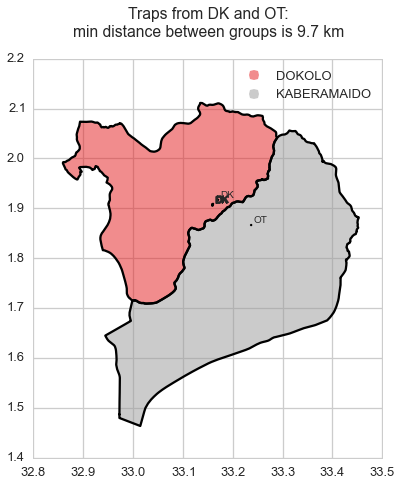

In [95]:
dk_trap = dk.geopy_point.iloc[0]
ot_trap = ot.geopy_point.iloc[0]

dk_ot_d = distance(dk_trap,ot_trap)
print dk_ot_d

plot_points_on_base_geometries(dk_ot,
                               uganda_gdf,
                               points_by_col='Location',
                               base_by_column="DNAME_2010",
                               base_legend=True,
                               buf=0.0001,
                               title="Traps from DK and OT:\nmin distance between groups is {:.3} km\n".format(dk_ot_d))

### Find samples with ID starting with `L` and `OG`: _Are they near Ogur?_

In [ ]:
og_mask = df_samples.banked_sample_id.apply(lambda x: x.upper().startswith('OT'))